# Description of the Purpose
The purpose of this notebook is to develop software that can simulate a range of driver behaviors on a spectrum from non-aggressive to aggressive. The software should be able to accept input parameters for speed limits over time (high and low limits), calculate a driver's speed according to these limits and a configurable level of driver aggressiveness, and potentially, relate the speed and aggressiveness level to energy consumption for the vehicle being simulated.

# Import Required Libraries
Import the necessary libraries, including pandas for data manipulation.

In [1]:
# Importing pandas library for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Display Data
Load the data from the CSV file located at 'C:\MEIN_PLATZ\Git\vehicle-testing-project\data\AI_DRIVER___WLTC.csv' and display the first 4 lines of the dataframe.

In [2]:

data_path = r'C:\MEIN_PLATZ\Git\vehicle-testing-project\data\AI_DRIVER___WLTC.csv'
df = pd.read_csv(data_path, sep=';')
df.head(4)

C:\Users\43664\AppData\Local\Temp\ipykernel_10152\3306498356.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep=';')


,recorder_time,SPEED_LOW_TOL,SPEED_UP_TOL,D_SPEED_ArtDriver_0,D_SPEED_ArtDriver_2,D_SPEED_ArtDriver_4,D_SPEED_ArtDriver_6,D_SPEED_ArtDriver_8,D_SPEED_ArtDriver_10,D_SPEED_ArtDriver_12,...,WORK_ArtDriver_84,WORK_ArtDriver_86,WORK_ArtDriver_88,WORK_ArtDriver_90,WORK_ArtDriver_92,WORK_ArtDriver_94,WORK_ArtDriver_96,WORK_ArtDriver_98,WORK_ArtDriver_100,Unnamed: 105
0,s,km/h,km/h,km/h,km/h,km/h,km/h,km/h,km/h,km/h,...,J,J,J,J,J,J,J,J,J,NaN
1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.1,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.2,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


# Data Exploration
Explore the data to understand its structure and the information it contains. This will help in the development of the simulation software.

In [3]:
df.head(4)
len(df)

18002

In [4]:
if 0 in df.index:
    df = df.drop(0, axis=0)


In [5]:
# Drop the column 'unnamed:'
if 'unnamed: 105' in df:
    df = df.drop('Unnamed: 105', axis=1)

#df = df.astype(float)
print("\nStatistical summary")
print(df.describe())


Statistical summary
       Unnamed: 105
count           0.0
mean            NaN
std             NaN
min             NaN
25%             NaN
50%             NaN
75%             NaN
max             NaN


In [6]:
# Convert the columns in dataframe to float
df = df.astype(float)

<Axes: xlabel='recorder_time'>

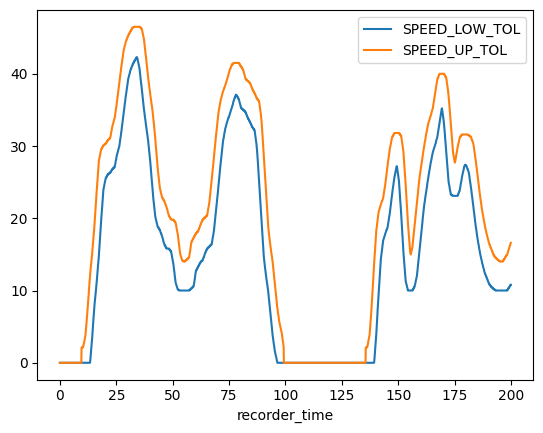

In [7]:
import numpy as np
df.head(2000).plot(x='recorder_time', y=['SPEED_LOW_TOL', 'SPEED_UP_TOL'])

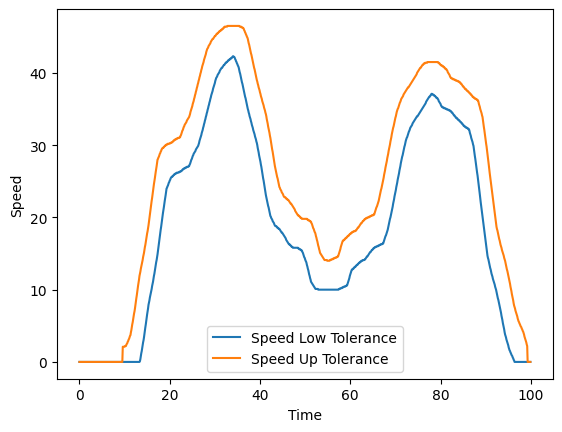

In [35]:
length = 1000
recorder_time_array = df['recorder_time'].values[:length]
speed_low_tol_array = df['SPEED_LOW_TOL'].values[:length]
speed_up_tol_array = df['SPEED_UP_TOL'].values[:length]
speed_driver_0_array = df['D_SPEED_ArtDriver_0'].values[:length]

plt.plot(recorder_time_array, speed_low_tol_array, label='Speed Low Tolerance')
plt.plot(recorder_time_array, speed_up_tol_array, label='Speed Up Tolerance')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()

### Downsampling

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

def apply_low_pass_filter(data, cutoff, fs):
    """
    Applies a low-pass Butterworth filter to the data.

    :param data: The input data (signal).
    :param cutoff: The cutoff frequency of the filter.
    :param fs: The sampling rate of the signal.
    :return: Filtered data.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(6, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def resample_data(data, factor, fs):
    """
    Resamples the given data by the specified factor with anti-aliasing.

    :param data: List or NumPy array of data points.
    :param factor: The factor by which to resample the data. Can be non-integer.
    :param fs: The original sampling rate of the data.
    :return: Resampled data.
    """
    if factor <= 0:
        raise ValueError("Factor must be a positive number")

    # Apply low-pass filter for anti-aliasing
    if factor < 1:  # Downsampling
        cutoff = 0.5 * factor * fs
        data = apply_low_pass_filter(data, cutoff, fs)

    # Original indices
    original_indices = np.arange(len(data))

    # New indices after applying the resampling factor
    new_length = len(data) / factor
    new_indices = np.linspace(0, len(data) - 1, int(new_length))

    # Linear interpolation
    resampled_data = np.interp(new_indices, original_indices, data)

    return resampled_data

def resample_time(time_array, factor):
    new_length = len(time_array) / factor
    resampled_time = np.linspace(time_array[0], time_array[-1], int(new_length))
    return resampled_time

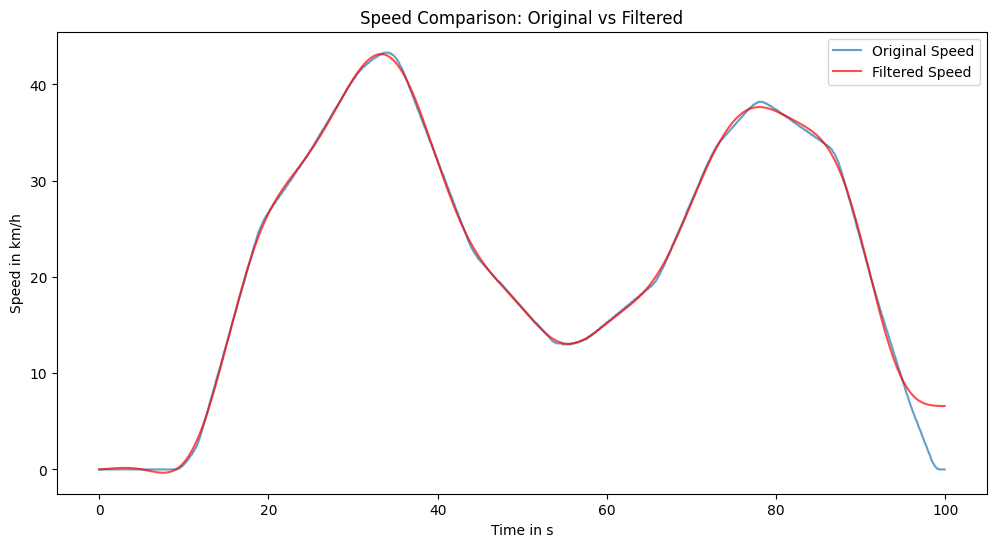

In [ ]:
fs = 1/(- recorder_time_array[0] + recorder_time_array[1])
cutoff = 0.1  # Cutoff frequency for filtering (example value)

# Apply the low-pass filter to the speed data
filtered_speed = apply_low_pass_filter(speed_driver_0_array, cutoff, fs)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(recorder_time_array, speed_driver_0_array, label='Original Speed', alpha=0.7)
plt.plot(recorder_time_array, filtered_speed, label='Filtered Speed', color='red', alpha=0.7)
plt.xlabel('Time in s')
plt.ylabel('Speed in km/h')
plt.title('Speed Comparison: Original vs Filtered')
plt.legend()
plt.show()

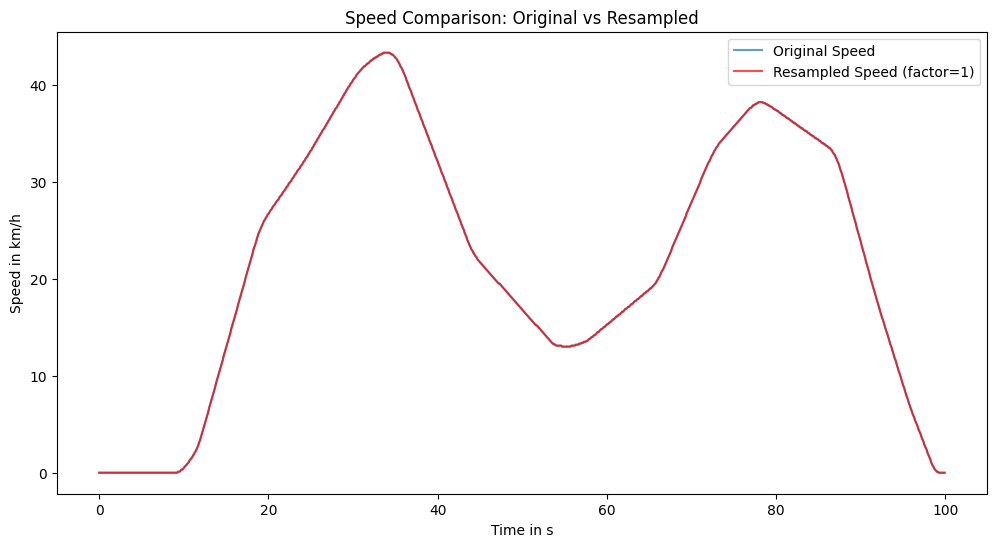

In [61]:
fs = 1/(- recorder_time_array[0] + recorder_time_array[1])
factor = 1

def resample_time_array(time_array, factor):
    new_length = len(time_array) / factor
    resampled_time = np.linspace(time_array[0], time_array[-1], int(new_length))
    return resampled_time

resampled_speed = resample_data(speed_driver_0_array, factor, fs)
high_limits = resample_data(speed_up_tol_array, factor, fs)
low_limits = resample_data(speed_low_tol_array, factor, fs)
resampled_time = resample_time_array(recorder_time_array, factor)


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(recorder_time_array, speed_driver_0_array, label='Original Speed', alpha=0.7)
plt.plot(resampled_time, resampled_speed, label=f'Resampled Speed (factor={factor})', color='red', alpha=0.7)
plt.xlabel('Time in s')
plt.ylabel('Speed in km/h')
plt.title('Speed Comparison: Original vs Resampled')
plt.legend()
plt.show()


### Algorithm Development

In [62]:
def fix_to_limits(value, low_limit, high_limit):
    if value > high_limit:
        return high_limit
    elif value < low_limit:
        return low_limit
    else:
        return value

def simulate_driver_behavior_with_reference_speed(reference_speed, speed_limits_low, speed_limits_high, iterations=10000):
    adjusted_speed_values = np.zeros(len(speed_limits_low))
    for _ in range(iterations):
        for i in range(len(speed_limits_high)):
            if i == 0:
                continue
            if i == 1:
                adjusted_speed_value = (reference_speed[i-1] + reference_speed[i])/2
                adjusted_speed_values[i-1] = fix_to_limits(adjusted_speed_value, speed_limits_low[i-1], speed_limits_high[i-1])
            else:
                adjusted_speed_value = (reference_speed[i-2] + reference_speed[i])/2
                adjusted_speed_values[i-1] = fix_to_limits(adjusted_speed_value, speed_limits_low[i-1], speed_limits_high[i-1])
                
        reference_speed = adjusted_speed_values
    
    return adjusted_speed_values

driver_speed = simulate_driver_behavior_with_reference_speed(high_limits, low_limits, high_limits)

In [63]:
def fix_to_limits(value, low_limit, high_limit):
    if value > high_limit:
        return high_limit
    elif value < low_limit:
        return low_limit
    else:
        return value

def simulate_driver_behavior_with_reference_speed(reference_speed, speed_limits_low, speed_limits_high, iterations=10000):
    adjusted_speed_values = np.zeros(len(speed_limits_low))
    for _ in range(iterations):
        for i in range(len(speed_limits_high)):
            if i % 2:
                continue
            if i == 0:
                continue
            if i == 2:
                adjusted_speed_value = (reference_speed[i-2] + reference_speed[i])/2
                adjusted_speed_values[i-1] = fix_to_limits(adjusted_speed_value, speed_limits_low[i-1], speed_limits_high[i-1])
            else:
                adjusted_speed_value = (reference_speed[i-3] + reference_speed[i])/2
                adjusted_speed_value = fix_to_limits(adjusted_speed_value, speed_limits_low[i-1], speed_limits_high[i-1])
                adjusted_speed_values[i-1] = adjusted_speed_value
                adjusted_speed_values[i-2] = adjusted_speed_value
                
        reference_speed = adjusted_speed_values
    
    return adjusted_speed_values

driver_speed_simon_alg = simulate_driver_behavior_with_reference_speed(high_limits, low_limits, high_limits)

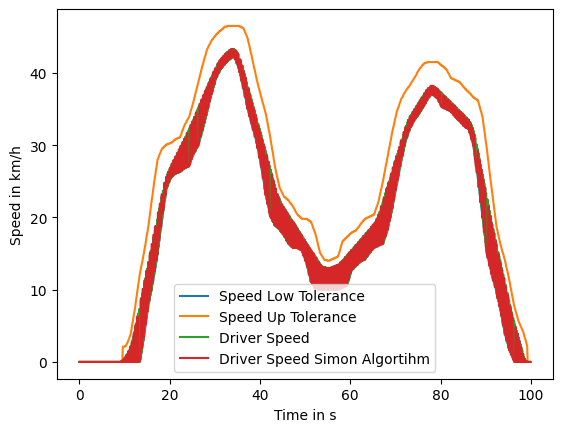

In [64]:

plt.plot(recorder_time_array, speed_low_tol_array, label='Speed Low Tolerance')
plt.plot(recorder_time_array, speed_up_tol_array, label='Speed Up Tolerance')
plt.plot(resampled_time, driver_speed, label='Driver Speed')
plt.plot(resampled_time, driver_speed_simon_alg, label='Driver Speed Simon Algortihm')
plt.xlabel('Time in s')
plt.ylabel('Speed in km/h')
plt.legend()

In [31]:
from tqdm import tqdm
driver_speeds = []

for iterations in tqdm(range(100, 2000, 100)):
    driver_speeds.append(simulate_driver_behavior_with_reference_speed(speed_up_tol_array, speed_low_tol_array, speed_up_tol_array, iterations))

100%|██████████| 19/19 [00:31<00:00,  1.68s/it]


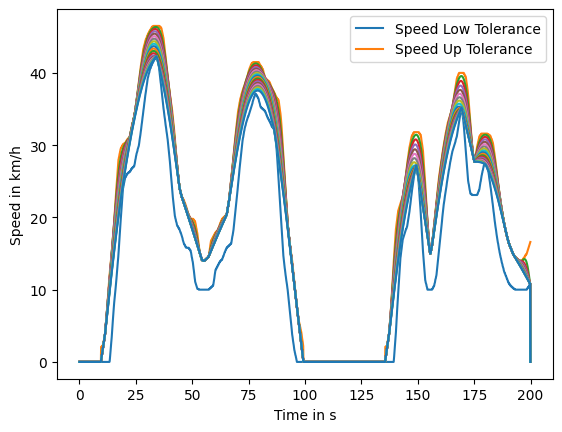

In [27]:
plt.plot(recorder_time_array, speed_low_tol_array, label='Speed Low Tolerance')
plt.plot(recorder_time_array, speed_up_tol_array, label='Speed Up Tolerance')
for speeds in driver_speeds:
    plt.plot(recorder_time_array, speeds)

plt.legend()
plt.xlabel('Time in s')
plt.ylabel('Speed in km/h')
plt.legend()

### Downsampling

In [15]:
import numpy as np
from scipy.signal import butter, filtfilt

def apply_low_pass_filter(data, cutoff, fs):
    """
    Applies a low-pass Butterworth filter to the data.

    :param data: The input data (signal).
    :param cutoff: The cutoff frequency of the filter.
    :param fs: The sampling rate of the signal.
    :return: Filtered data.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(6, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def resample_data(data, factor, fs):
    """
    Resamples the given data by the specified factor with anti-aliasing.

    :param data: List or NumPy array of data points.
    :param factor: The factor by which to resample the data. Can be non-integer.
    :param fs: The original sampling rate of the data.
    :return: Resampled data.
    """
    if factor <= 0:
        raise ValueError("Factor must be a positive number")

    # Apply low-pass filter for anti-aliasing
    if factor < 1:  # Downsampling
        cutoff = 0.5 * factor * fs
        data = apply_low_pass_filter(data, cutoff, fs)

    # Original indices
    original_indices = np.arange(len(data))

    # New indices after applying the resampling factor
    new_length = len(data) / factor
    new_indices = np.linspace(0, len(data) - 1, int(new_length))

    # Linear interpolation
    resampled_data = np.interp(new_indices, original_indices, data)

    return resampled_data

def resample_time(time_array, factor):
    new_length = len(time_array) / factor
    resampled_time = np.linspace(time_array[0], time_array[-1], int(new_length))
    return resampled_time

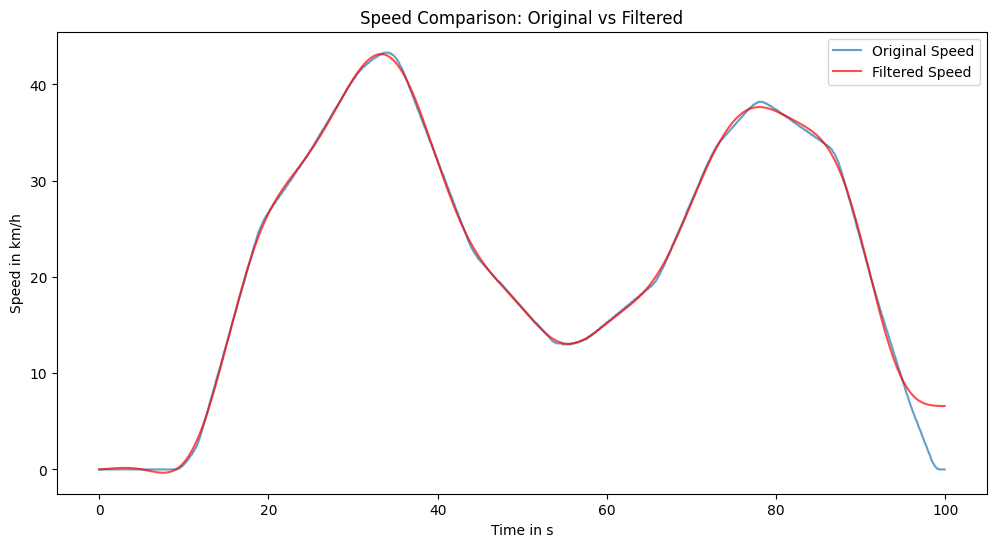

In [41]:
fs = 1/(- recorder_time_array[0] + recorder_time_array[1])
cutoff = 0.1  # Cutoff frequency for filtering (example value)

# Apply the low-pass filter to the speed data
filtered_speed = apply_low_pass_filter(speed_driver_0_array, cutoff, fs)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(recorder_time_array, speed_driver_0_array, label='Original Speed', alpha=0.7)
plt.plot(recorder_time_array, filtered_speed, label='Filtered Speed', color='red', alpha=0.7)
plt.xlabel('Time in s')
plt.ylabel('Speed in km/h')
plt.title('Speed Comparison: Original vs Filtered')
plt.legend()
plt.show()

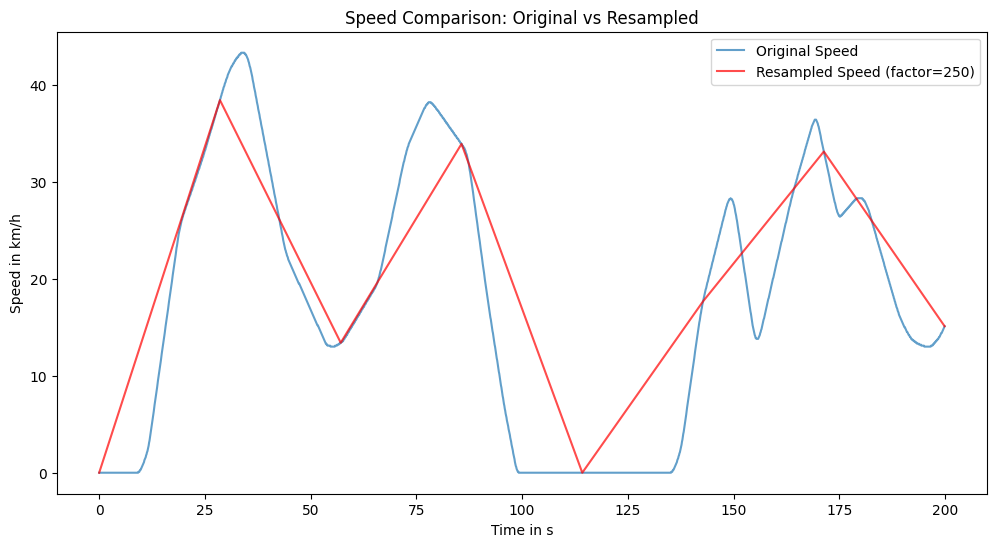

In [30]:
fs = 1/(- recorder_time_array[0] + recorder_time_array[1])
factor = 250

def resample_time_array(time_array, factor):
    new_length = len(time_array) / factor
    resampled_time = np.linspace(time_array[0], time_array[-1], int(new_length))
    return resampled_time

resampled_speed = resample_data(speed_driver_0_array, factor, fs)

resampled_time = resample_time_array(recorder_time_array, factor)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(recorder_time_array, speed_driver_0_array, label='Original Speed', alpha=0.7)
plt.plot(resampled_time, resampled_speed, label=f'Resampled Speed (factor={factor})', color='red', alpha=0.7)
plt.xlabel('Time in s')
plt.ylabel('Speed in km/h')
plt.title('Speed Comparison: Original vs Resampled')
plt.legend()
plt.show()
